## Predicting Absenteeism 


This report analyses all the data available from HappyForce in order to predict workforce absenteeism & undestand the drivers.

Objectives
* Develop machine learning to **predict** absenteeism - via Support Vector Machine & Random Forest Tree algorithms
* Analyse which **features** are likely to predict absenteeism -  via Recursive Feature Elimination (RFE) on the "corporate-view" of the data by date.
* Build categories for different **types** of employees by their motivation - via KMeans Clustering on the "individual-view" of the data by employee. 
* Discuss what **actions** can be taken within an organisation to avoid absenteeism.

(c 950 words / of which 625 insights)

### Import Libraries

In [127]:
# Importing libraries: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

from ipywidgets import interact, interact_manual

# Supressing warnings for published version:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import datetime  ## to manipulate dates in the absenteeism dataframe

### Preview Data

In [128]:
# Import data & preview
PATH_TO_DATA = './predict-employee-ausentism/'

In [129]:
# A listing of all companies available on the dataset
df_dict = pd.read_csv(PATH_TO_DATA + 'company_dictionary.csv', header=0)
df_dict.head()  ## The HappyForce dataset contains data relating to one company, C1, a Manufacturing company in Madrid. 

,companyAlias,creationDate,type,status,timezone
0,C1,2017-04-26 09:04,MANUFACTURING,ACTIVE,Europe/Madrid


In [130]:
# A listing of all employees of the companies on the dataset. Their status on the system and some useful information.
df_participation = pd.read_csv(PATH_TO_DATA + 'lastParticipationExists.csv', header=0)
df_participation.head(1)

,employee,companyAlias,numVotes,lastParticipationDate,timezone,stillExists,deletedOn
0,l8,C1,285,3/8/19 1:03,Europe/Madrid,True,NaN


In [131]:
# A listing of all votes registered on Happyforce to the question "How are you today?" from the employees on the dataset.
## 1 to 4: Very Bad, Bad, Good, Very Good
df_votes = pd.read_csv(PATH_TO_DATA + 'votes.csv', header=0)
df_votes.head(1)

,employee,companyAlias,voteDate,vote
0,2ER,C1,2017-05-03 02:05,1


In [132]:
# A listing of all comments registered by the employees on the dataset.
## When the employees submit a comment, they have to chose between 4 categories: INFORMATION, CONGRATULATION, SUGGESTION or SOMETHING IS WRONG 
### (note: not all the entries have these information since that feature was added later)
df_comment = pd.read_csv(PATH_TO_DATA + 'comments_by_employees_in_anonymous_forum.csv', header=0)
df_comment.head(1)
#df_comment.shape ## This will be the originating comment ... that generates the likes/dislikes

,employee,companyAlias,commentId,commentLength,likes,dislikes,commentDate,feedbackType
0,aKP,C1,5909b33da2ede4000473da6f,17,9,0,2017-05-03 12:05,OTHER


In [133]:
# Which Interaction is performed -1 -> disagree / 1 agree / 2 reply.
df_interaction = pd.read_csv(PATH_TO_DATA + 'commentInteractions.csv', header=0)
df_interaction.head(1)
#df_interaction.shape  ## This is the bigger dataset, as it shows who has liked/disliked each comment

,employee,companyAlias,interaction,commentId,actionDate
0,YX4,C1,1,5909b33da2ede4000473da6f,2017-05-03 12:05


In [134]:
df_absentee = pd.read_csv(PATH_TO_DATA + 'employeeAbsenteeism.csv', header=0)
df_absentee.head(1)  ## This is the y variable - what you are trying to predict

,employee,companyAlias,from,to,reason
0,19Q,C1,10/1/18 0:10,10/26/18 0:10,Workplace accident


In [135]:
# Validated: The HappyForce dataset contains data relating to one company, C1, a Manufacturing company in Madrid. 
df_dict.companyAlias.unique()  ## no further insights
df_comment.companyAlias.unique()
df_interaction.companyAlias.unique()
df_absentee.companyAlias.unique()
df_participation.companyAlias.unique()
df_votes.companyAlias.unique()

array(['C1'], dtype=object)

### Absenteeism / Votes / Comment / Interactions - analyse and combine BY DATE (df_classifier)

To enable the prediction of the number of absenteeism at a given date, the raw data (covering absenteeism, votes etc) is cleaned, analysed and combined into a master dataset BY DATE i.e. number of absentees at a given date vs. average score, comments etc.

#### a) Calculate the number of absent workers per day

In [136]:
### Pass dates to datetime format
df_absentee['from'] = pd.to_datetime(df_absentee['from'])
df_absentee['to'] = pd.to_datetime(df_absentee['to'])

df_absentee = df_absentee.sort_values(by=['from'])  ## sort by from date
df_absentee.reset_index(inplace = True, drop = True) ## reset index by sorted values, so can pick up index correctly

#df_absentee.tail()

In [137]:
absent_date = {}  ## initialise dictionary for absent index : absent dates

for i in range(df_absentee.shape[0]):  ## iterate through all rows in the dataframe
    #print (i)
    start = df_absentee['from'][i]
    end = df_absentee['to'][i]
 
    def date_range(start, end):
        r = (end+datetime.timedelta(days=1)-start).days
        return [start+datetime.timedelta(days=i) for i in range(r)]

    dateList = date_range(start, end)
    dateList = [date.strftime('%Y-%m-%d') for date in dateList]  ## format to yyyy-mm-dd
    #print(dateList)

    absent_date.update( {i : [dateList]} )  ## add to absent_date dictonary

#print(absent_date)

absent_date_df = pd.DataFrame(absent_date)  ## convert dictionary to dataframe
absent_date_df = absent_date_df.T  ## transpose so index is rows rather than column names

absent_date_df.columns = ['absent_date']  ## change column name
absent_date_df.head()  ## preview data wrangling



## Add the absent_date to orig dataframe, as a column
df_absentee = pd.concat([df_absentee, absent_date_df], axis=1) 
df_absentee.head()

## Convert to yyyy-mm-dd date format
df_absentee['from'] = df_absentee['from'].dt.strftime('%Y-%m-%d')
df_absentee['to'] = df_absentee['to'].dt.strftime('%Y-%m-%d')

#df_absentee.tail()

In [138]:
## Count absentees per day
absent_count = pd.Series(sum([item for item in df_absentee.absent_date], [])).value_counts()  ## counts number of abseentees at each date
absent_count = absent_count.rename_axis('absent_date').reset_index(name='absent_count')  ## format series output into dframe
absent_count = absent_count.sort_values(by=['absent_date']).reset_index(drop = True)  ## sort by absent date & reindex
#absent_count.tail()

#### b) Calculate the average vote score per day, re. "How are you today?"

In [139]:
### Format into datetime, so can calculate mean (using .resample method)
df_votes.voteDate = pd.to_datetime(df_votes.voteDate, format="%Y-%m-%d") ## format to datetime
#df_votes.head()

In [140]:
### Calculate the mean of votes per day
## 1 to 4: Very Bad, Bad, Good, Very Good
votes_mean = df_votes.resample('D', on='voteDate').mean().reset_index().sort_values(by='voteDate')
votes_mean['voteDate'] = votes_mean['voteDate'].dt.strftime('%Y-%m-%d') ## Convert to yyyy-mm-dd date format, so can join later

#votes_mean.head()

#### c) Comments: calculate the total comment length, likes, dislikes per day; and frequency of each feedback type per day

In [141]:
### Format into datetime, so can calculate sums (using .resample method)
df_comment.commentDate = pd.to_datetime(df_comment.commentDate, format="%Y-%m-%d") ## format to datetime
#df_comment.head(10)

In [142]:
# Calculate the total comment length, likes, dislikes per day
comment_sum = df_comment.resample('D', on='commentDate').sum().reset_index().sort_values(by='commentDate') ## needs to be in datetime
comment_sum['commentDate'] = comment_sum['commentDate'].dt.strftime('%Y-%m-%d') ## Convert to yyyy-mm-dd date format, so can join later
comment_sum.head()

# Convert to yyyy-mm-dd date format, so can do various count manipulations
df_comment['commentDate'] = df_comment['commentDate'].dt.strftime('%Y-%m-%d')

# Count number of comments per day
comment_count = pd.Series(df_comment.commentDate).value_counts()  ## counts number of comments at each date
comment_count = comment_count.rename_axis('commentDate').reset_index(name='comment_count')  ## format series output into dframe
comment_count = comment_count.sort_values(by=['commentDate']).reset_index(drop = True)  ## sort by absent date & reindex
comment_count.head()

# Calculate frequency of each feedback type per day
## When the employees submit a comment, they have to chose between 4 categories: INFORMATION, CONGRATULATION, SUGGESTION or SOMETHING IS WRONG 
feedbackType_count = df_comment.pivot_table(index="commentDate", columns='feedbackType', aggfunc='size', fill_value=0)
feedbackType_count.head()

# Join into one comments dataframe: total comment length, likes, dislikes; Count number of comments; Frequency of each feedback type per day
comment = pd.merge(comment_sum, comment_count, on='commentDate', how = 'outer')
comment = pd.merge(comment, feedbackType_count, on='commentDate', how = 'outer')
#comment.head()

#### d) Frequency of each interaction type per day

In [143]:
# Format into datetime, so can calculate sums (using .resample method)
df_interaction.actionDate = pd.to_datetime(df_interaction.actionDate, format="%Y-%m-%d") ## format to datetime

# Convert to yyyy-mm-dd date format, so can do various count manipulations
df_interaction['actionDate'] = df_interaction['actionDate'].dt.strftime('%Y-%m-%d')

In [144]:
# Calculate frequency of each interaction type per day
interactionType_count = df_interaction.pivot_table(index="actionDate", columns='interaction', aggfunc='size', fill_value=0)

# Which Interaction is performed -1 -> disagree / 1 agree / 2 reply; relabel columns
interactionType_count.rename(columns = {-1:'disagree', 1:'agree'}, inplace = True) 

#interactionType_count.head() ## this gives the same results as likes/dislikes count
## BUT: may be useful later on to ID which employee dis/liked a comment vs employee that posted the comment (train/test split)

#### e) Absenteeism / Votes / Comment / (Interaction) - combine into master dataframe BY DATE

In [145]:
# Join into one dataframe: Absenteeism / Votes / Comment / (Interaction) per day
df_classifier = pd.merge(absent_count, votes_mean, left_on='absent_date', right_on='voteDate', how = 'outer')  ## join Absenteeism / Votes
df_classifier = pd.merge(df_classifier, comment, left_on='voteDate', right_on='commentDate', how = 'outer')  ## then join to Comment
df_classifier = pd.merge(df_classifier, interactionType_count, left_on='commentDate', right_on='actionDate', how = 'outer')  ## then join to Interaction
df_classifier.tail() ## fill NaN?! e.g. instances where there might be a vote that day, but no absences.


# Create master date column of all the various dates e.g. 'absent_date', 'voteDate', 'commentDate'
## Extract the date columns into individual dataframes
d1 = df_classifier['absent_date'].dropna()
d1 = d1.reset_index(name='date')  ## format series output into dframe
d1.head()

d2 = df_classifier['voteDate'].dropna()
d2 = d2.reset_index(name='date')  ## format series output into dframe
d2.head()

d3 = df_classifier['commentDate'].dropna()
d3 = d3.reset_index(name='date')  ## format series output into dframe
d3.head()

## Join into one dates dataframe, using date as the key
date = pd.merge(d1, d2, on='date', how = 'outer')
date = pd.merge(date, d3, on='date', how = 'outer')
date.tail()

## Append the master date column to the cleaned dataset
df_classifier = pd.concat([df_classifier, date['date']], axis=1) ## row index already aligned
df_classifier.tail()


# Further cleaning
## Fill null values with '0'
df_classifier.fillna(value=0, inplace=True)
df_classifier.tail()


## Convert date to datetime, then sort serially from oldest to recent
df_classifier['date'] = pd.to_datetime(df_classifier['date'])  ## convert to datetime
df_classifier = df_classifier.sort_values(by='date').reset_index(drop=True) ## sort & reindex
df_classifier['date'] = df_classifier['date'].dt.strftime('%Y%m%d') ## Convert to yyyymmdd date format,
df_classifier.head()

## Clean the dataframe further by dropping "absent_date", "voteDate", and "commentDate" columns - possibly redundant
#df_classifier.columns.tolist()  ## extract column names into list
### column names to retain
col = ['date',
 'absent_count',
 'vote',
 'commentLength',
 'likes',
 'dislikes',
 'comment_count',
 'CONGRATULATION',
 'CRITICISM',
 'INFORMATION',
 'OTHER',
 'SUGGESTION',
 'disagree',
 'agree']

df_classifier = df_classifier[col]
df_classifier.tail()

,date,absent_count,vote,commentLength,likes,dislikes,comment_count,CONGRATULATION,CRITICISM,INFORMATION,OTHER,SUGGESTION,disagree,agree
673,20190307,0.0,2.628440,1640,197,29,19.0,2.0,0.0,4.0,13.0,0.0,37.0,152.0
674,20190308,0.0,2.602941,1345,164,76,13.0,1.0,1.0,4.0,6.0,1.0,57.0,227.0
675,20190309,0.0,2.609195,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,68.0
676,20190310,0.0,2.596154,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,39.0
677,20190311,0.0,2.596774,122,1,1,1.0,0.0,0.0,0.0,0.0,1.0,6.0,10.0


### Objective 1: Develop machine learning to predict absenteeism - svm / trees

Machine Learning algorithms is applied to the master dataset BY DATE, to predict absenteeism on a given date.

#### a) Normalise Data & Split into Training & Test set (25%)

In [146]:
# Normalise the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() ## create the scaler
scaler.fit(df_classifier[col]) ## fit the scaler data

df_classifier_sc = df_classifier.copy() ## create copy of dataframe so you keep the orig 
df_classifier_sc[col] = scaler.transform(df_classifier[col])  ## scale the dataframe
#df_classifier_sc.head()

In [147]:
# Split the dataframe into Y (variable we are predicting) and x (possible explanatory factors)

## Select the y and X columns
col_Y = ['absent_count'] 
col_X=[i for i in col if i not in col_Y] ## rest of the columns

## Split dataframe into Y and X 
Y = df_classifier_sc[col_Y]
X = df_classifier_sc[col_X]
#X.head()

In [148]:
# Serial data: retain most recent 25% of data as test set (can't shuffle or randomly sample as time order important)
train_pct_index = int(0.75 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = Y[:train_pct_index], Y[train_pct_index:]

In [149]:
# Cross-validation: time series 10-split to train model to avoid overfitting
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)  ## create 10 subsamples to train

#for train, test in tscv.split(X_train):
    #print("%s %s" % (train, test))  ## to print what the subsamples look like

#### b) Support Vector Machine (svm)

Source: https://medium.com/coinmonks/support-vector-regression-or-svr-8eb3acf6d0ff

SVM algorithm in a regression context, tries to find the line of best fit that contains the maximum numbers of points within the corresponding threshold boundaries. 

In [150]:
scoring = 'r2' ## coefficient of determination R^2 as regression problem, rather than classification ('accuracy')

from sklearn.svm import SVR
svr = SVR()  ## regression
results = model_selection.cross_val_score(svr, X_train, y_train, cv=tscv, scoring=scoring)
print("Support Vector Machine cross-validation average R^2: %.3f" %(results.mean()))

Support Vector Machine cross-validation average R^2: 0.530


In [151]:
# SVR: Performance on test set
svr.fit(X_train, y_train)

# Coefficient of determination R^2 of the prediction; best possible score is 1.0
svm_confidence = svr.score(X_test, y_test)
print("Support Vector Machine test-set R^2: %.3f" %(svm_confidence))

Support Vector Machine test-set R^2: -0.055


#### c) Random Forest Regressor (tree)

Source: https://en.wikipedia.org/wiki/Random_forest

Random Forest algorithm in a regression context, constructs a number of trees at training time, and outputs the mean prediction of the individual tree. 

In [152]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
results = model_selection.cross_val_score(rf, X_train, y_train, cv=tscv, scoring=scoring)
print("Random Forest Regressor cross-validation average R^2: %.3f" %(results.mean()))

Random Forest Regressor cross-validation average R^2: 0.294


In [153]:
# Random Forest: Performance on test set
rf.fit(X_train, y_train)

# Coefficient of determination R^2 of the prediction; best possible score is 1.0
rf_confidence = rf.score(X_test, y_test)
print("Random Forest test-set R^2: %.3f" %(rf_confidence))

Random Forest test-set R^2: -0.119


#### d) Plot absence prediction vs actuals (test data)

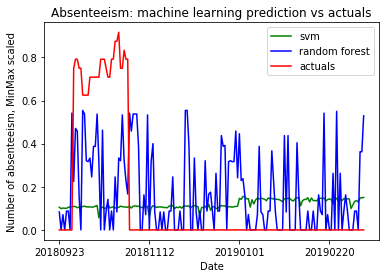

In [155]:
# SVM & random forest prediction on test set
svm_prediction = svr.predict(X_test)
rf_prediction = rf.predict(X_test)

# Plot prediction vs actuals
fig = plt.figure()
ax = plt.axes()
x_axes = df_classifier['date'][train_pct_index:] ## x-axes = dates on the test set

plt.plot(x_axes, svm_prediction, '-g', label='svm')
plt.plot(x_axes, rf_prediction, '-b', label='random forest')
plt.plot(x_axes, y_test, '-r', label='actuals')

plt.title("Absenteeism: machine learning prediction vs actuals")
plt.xlabel("Date")
plt.ylabel("Number of absenteeism, MinMax scaled")
plt.legend()

import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=50) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

**INSIGHT** - The number of absentees predicted by the Support Vector Machine and Random Forest ML algorithms are brittle. 
* The ML models were trained using time-series cross-validation that serially splits the training data into 10 sub-samples, to avoid the problem of overfitting the models. The average Coefficient of Determination (R^2) was calculated across these samples, to check how the predicted absenteeism is aligned to the actual absenteeism. SVR leads to a higher R^2 score (0.530) than Random Forest (0.294) - R^2 ranges from 0 to 1, with 1 being the best outcome. **Cross-validation suggest that SVR is the better model of the two**, with c53% of the variance in the dependent variable (number of absentees per day) is predictable from the independent variables e.g. average score, comment length/count, number of dis/likes, feedback type, dis/agree etc
* The models were then tested using the test dataset (the most recent 25% of data that was not used in training/validation) to assess brittleness. **Both models led to negative test R^2 scores**: SVR (-0.055) & Random Forest (-0.119). This implies that the mean of the test data provides a better fit to the outcomes than do the fitted model values. In short, our **machine learning models do a poor job are predicting the number of absentees per day** i.e. ML models are brittle. 
* Why the poor predictions? One possible reason is that we have used the default hyper-parameters for the ML models, and have not taken the time to fine-tune these parameters to see if we can improve the predictions. This is a possible future avenue of investigation.

### Objective 2: Analyse which features are likely to predict absenteeism
#### Feature Selection - Recursive Feature Elimination (RFE) 
<br>
Source: https://towardsdatascience.com/predict-employee-turnover-with-python-da4975588aa3
<br>
<br>
RFE works by recursively removing variables and building a model on those variables that remain. It uses the model accuracy to identify which variables (and combination of variables) contribute the most to predicting absenteeism. 

In [156]:
## Use Recursive Feature Elimination to select which features are likely to predict absenteeism
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

col_X.remove('date')  ## remove 'date' column as giving error in RFE

# Select y, x columns from the un-normalised data (gives error if using normalised data)
y = df_classifier[col_Y]
x = df_classifier[col_X] 

model = LogisticRegression()
rfe = RFE(model)
rfe = rfe.fit(x, y)
print(rfe.support_)
print(rfe.ranking_)

[ True False False False  True  True  True False  True  True False False]
[1 7 6 3 1 1 1 2 1 1 5 4]


In [157]:
## Convert the rankings into features names, and sort by best predictors to worse
ranking_dict = dict(zip(col_X, rfe.ranking_)) ## create dictionary: feature name to ranking
#print(ranking_dict)
[(str(key)+" = "+ str(value)) for (key, value) in sorted(ranking_dict.items(), key=lambda x: x[1])]  ## sort by best predictors to worse

['vote = 1',
 'comment_count = 1',
 'CONGRATULATION = 1',
 'CRITICISM = 1',
 'OTHER = 1',
 'SUGGESTION = 1',
 'INFORMATION = 2',
 'dislikes = 3',
 'agree = 4',
 'disagree = 5',
 'likes = 6',
 'commentLength = 7']

**INSIGHT** - RFE suggests there are 6 features that are likely to predict absenteeism:
* **vote**: average vote score per day, re. "How are you today?"
* **comment_count**: number of comments per day
* **CONGRATULATION, CRITICISM, OTHER, SUGGESTION**: frequency of these feedback type per day

### Absenteeism / Votes / Comment / Interactions / Participation - analyse and combine BY EMPLOYEE (df_employee)

To enable the categorisation of employees by motivation, a second master dataset is created BY EMPLOYEE i.e. employee ID vs frequency of each absent type, vote score etc.

#### a) Calculate frequency of each absent type by employee

In [158]:
#df_absentee.head()

# Calculate frequency of each absent type, by employee
## Note: If an employee has been away for 7 days straight, this is counted as frequency 1, rather than 7
eabsent = df_absentee.pivot_table(index="employee", columns='reason', aggfunc='size', fill_value=0)
#eabsent.head()

#df_absentee[df_absentee["employee"] == '2ER']  ## sense check: filter for a specific employee

#### b) Calculate the min, max, mean vote score and total count of votes by employee, re. "How are you today?

In [159]:
#df_votes.head()

# Calculate min, max, mean vote score votes by employee
evotes = df_votes.pivot_table(index="employee", aggfunc={'vote': [min, max, 'mean']}, fill_value=0)
#evotes.head()

#df_votes[df_votes["employee"] == '1Bl']  ## sense check: filter for a specific employee
## TO DO: rename column with vote_ prefix

#### c) Comments: calculate the total comment length, likes, dislikes per employee; and frequency of each feedback type by employee

In [160]:
#df_comment.head()

# Calculate comments posted by employee, and amounts of dis/likes to comment by other employees (min, max, mean)
ecommentstat = df_comment.pivot_table(index="employee", aggfunc={'commentLength': [min, max, 'mean'],
                                                            'likes': [min, max, 'mean'],
                                                             'dislikes': [min, max, 'mean'],
                                                             'feedbackType': ['count'],
                                                            }, fill_value=0)
ecommentstat.head()

# Calculate frequency of each comment type, by employee
efeedbackType_count = df_comment.pivot_table(index="employee", columns='feedbackType', aggfunc='size', fill_value=0)
efeedbackType_count.head()

# Join into one comments dataframe: comment length, likes, dislikes; Count number of comments; Frequency of each feedback type by employee
ecomment = pd.merge(ecommentstat, efeedbackType_count, on='employee', how = 'outer')
#ecomment.head()

#### d) Frequency of each interaction type by employee

In [161]:
#df_interaction.head()

# Calculate frequency of each interaction type, by employee
einteraction = df_interaction.pivot_table(index="employee", columns='interaction', aggfunc='size', fill_value=0)

# Which Interaction is performed -1 -> disagree / 1 agree / 2 reply; relabel columns
einteraction.rename(columns = {-1:'disagree', 1:'agree'}, inplace = True) 
#einteraction.head()

#### e) Absenteeism / Votes / Comment / Interaction / Participation - combine into master dataframe BY EMPLOYEE

In [162]:
# Combine into master dataframe BY EMPLOYEE 
df_employee = pd.merge(df_participation, eabsent, on='employee', how = 'outer')
df_employee = pd.merge(df_employee, evotes, on='employee', how = 'outer')
df_employee = pd.merge(df_employee, ecomment, on='employee', how = 'outer')
df_employee = pd.merge(df_employee, einteraction, on='employee', how = 'outer')


# Further cleaning
## Fill null values with '0'
df_employee.fillna(value=0, inplace=True)

## Drop unecessary columns (all employees are from same company C1)
df_employee = df_employee.drop(['companyAlias'], axis=1)

## Convert column names to string
emp_col = df_employee.columns.tolist()  ## extract orig column names to list
emp_col = [str(i) for i in emp_col]  ## convert elements to string
df_employee.columns = emp_col

## Convert date to datetime
df_employee['lastParticipationDate'] = pd.to_datetime(df_employee['lastParticipationDate'])  ## convert to datetime
df_employee['lastParticipationDate'] = df_employee['lastParticipationDate'].dt.strftime('%Y%m%d') ## Convert to yyyymmdd date format

df_employee['deletedOn'] = pd.to_datetime(df_employee['deletedOn'])  ## convert to datetime
df_employee['deletedOn'] = df_employee['deletedOn'].dt.strftime('%Y%m%d') ## Convert to yyyymmdd date format

## Convert 'timezone' column to string, so LabelEncoder works (previously filled null values with 0)
df_employee['timezone'] = df_employee['timezone'].astype(str)

df_employee.head()

,employee,numVotes,lastParticipationDate,timezone,stillExists,deletedOn,Common sickness or accident not related to the job,Long term sick leave,Non job related sickness,Workplace accident,...,"('likes', 'max')","('likes', 'mean')","('likes', 'min')",CONGRATULATION,CRITICISM,INFORMATION,OTHER,SUGGESTION,disagree,agree
0,l8,285.0,20190308,Europe/Madrid,True,19700101,0.0,0.0,0.0,0.0,...,39.0,7.565217,0.0,2.0,0.0,2.0,17.0,2.0,33.0,35.0
1,Xv,143.0,20180421,Europe/Berlin,True,19700101,0.0,0.0,0.0,0.0,...,28.0,25.000000,22.0,2.0,0.0,0.0,0.0,0.0,6.0,202.0
2,w7,381.0,20190311,Europe/Madrid,True,19700101,0.0,0.0,0.0,0.0,...,38.0,19.500000,6.0,1.0,0.0,1.0,2.0,0.0,79.0,426.0
3,jE,173.0,20190301,Europe/Madrid,True,19700101,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0
4,QP,312.0,20190308,Europe/Berlin,True,19700101,0.0,0.0,0.0,0.0,...,28.0,4.750000,0.0,1.0,0.0,0.0,7.0,0.0,53.0,174.0


### Objective 3: Build categories for different **types** of employees (by motivation)

Clustering algorithms is applied to the master dataset BY EMPLOYEE to categorise different types of employees.

#### a) Encode categorical data & normalise data

In [163]:
# Apply label Encoder from Scikit Learn to categorical columns
from sklearn.preprocessing import LabelEncoder

## Encode categorial columns
df_employee_encode = df_employee.copy() ## create a copy, so retain orig
df_employee_encode[['timezone', 'stillExists']] = df_employee_encode[['timezone', 'stillExists']].apply(LabelEncoder().fit_transform)
df_employee_encode.head()

## Normalise the data
from sklearn.preprocessing import MinMaxScaler

emp_col.remove('employee')  ## want to retain employee ID, and not normalise

scaler = MinMaxScaler() ## create the scaler
scaler.fit(df_employee_encode[emp_col]) ## fit the scaler data

df_employee_sc = df_employee_encode.copy() ## create copy of dataframe so you keep the orig 
df_employee_sc[emp_col] = scaler.transform(df_employee_encode[emp_col])  ## scale the dataframe
#df_employee_sc.head()

#### b) Cluster employees

To determine the appropriate number of clusters, the Silhouette Score is calculated and a Dendrogram plotted - these methods suggests 5 clusters/personas would be optimal. **KMeans** algorithm is then applied to the data to cluster the employees into the 5 personas. 

In [164]:
# Select relevant columns to base clustering on
exc_col = ['employee', 'lastParticipationDate', 'stillExists', 'deletedOn']  ## not related to motivation
cluster_col = [i for i in emp_col if i not in exc_col]

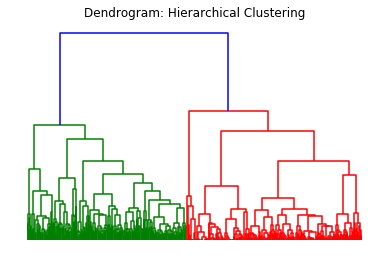

In [165]:
# Hierarchical Dendrograms to determine number of clusters

# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# create dendrogram
points = df_employee_sc[cluster_col]

fig, ax = plt.subplots()
ax.axis('off')
plt.title('Dendrogram: Hierarchical Clustering')

dendrogram = sch.dendrogram(sch.linkage(points, method='ward'))

In [166]:
# import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Calculate silhouette score
range_n_clusters = list(range(2,15))

d = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters = n_clusters, random_state=42)
    
    preds = clusterer.fit_predict(points)
    centers = clusterer.cluster_centers_
    score = silhouette_score(points, preds, metric='euclidean')
    
    d.append({'n_clusters': n_clusters, 'silhouette score': score})

d = pd.DataFrame(d)
d.head(10) 

,n_clusters,silhouette score
0,2,0.244095
1,3,0.169023
2,4,0.184677
3,5,0.223491
4,6,0.195799
5,7,0.195617
6,8,0.189396
7,9,0.202276
8,10,0.205138
9,11,0.205162


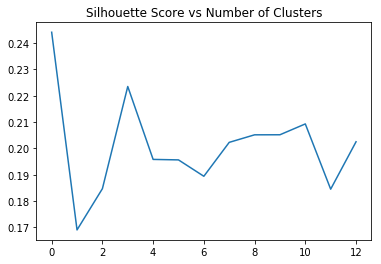

In [167]:
# Plot silhouette score for varying number of clusters
plt.title('Silhouette Score vs Number of Clusters')
d['silhouette score'].plot.line(x = d['n_clusters'] )

## TO DO: correct the labelling of x-axis 

In [168]:
# create kmeans object
kmeans = KMeans(n_clusters=5, random_state=42) ## dendrogram suggests 4 clusters

# fit kmeans object to data
kmeans.fit(points)

# Add the resulting cluster to each data point
points['clusters'] = kmeans.labels_

# Calculate the average
centroids = points.groupby(['clusters']).mean()
centroids

,numVotes,timezone,Common sickness or accident not related to the job,Long term sick leave,Non job related sickness,Workplace accident,"('vote', 'max')","('vote', 'mean')","('vote', 'min')","('commentLength', 'max')",...,"('likes', 'max')","('likes', 'mean')","('likes', 'min')",CONGRATULATION,CRITICISM,INFORMATION,OTHER,SUGGESTION,disagree,agree
clusters,,,,,,,,,,,,,,,,,,,,,
0,0.132533,0.804020,0.033920,0.005025,0.000000,0.002513,0.929648,0.763336,0.500000,0.009746,...,0.018239,0.013580,0.003029,0.003853,0.002513,0.000516,0.005722,0.000838,0.004380,0.016120
1,0.644344,0.803763,0.062500,0.000000,0.000000,0.012097,0.979839,0.701862,0.308468,0.097825,...,0.215532,0.140836,0.022757,0.028226,0.012097,0.005040,0.047210,0.022849,0.055151,0.125002
2,0.201769,0.810036,0.032258,0.000000,0.000000,0.000000,0.962366,0.708536,0.341398,0.152316,...,0.239745,0.270551,0.147886,0.013620,0.026882,0.006528,0.026372,0.039427,0.020072,0.055591
3,0.010964,0.571429,0.053571,0.071429,0.071429,0.000000,0.071429,0.062500,0.053571,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000412,0.001522
4,0.641987,0.792453,0.108491,0.009434,0.000000,0.000000,0.995283,0.697747,0.301887,0.355340,...,0.512229,0.246319,0.006203,0.100000,0.066038,0.084485,0.260846,0.126834,0.204426,0.319973


In [169]:
# Calculate the size of each cluster
points.groupby(['clusters']).size()  ## dendrogram / silhouette suggests that 5 clusters is sufficient

clusters
0    199
1    124
2     93
3     14
4     53
dtype: int64

In [170]:
# Visualise the clusters 
@interact(persona=[i for i in range(5)])
def show_plot(persona):
    centroids.iloc[persona].plot(kind='bar', color = 'blue')
    plt.title('Employee Persona')

interactive(children=(Dropdown(description='persona', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_class…

**INSIGHT** - The 5 personas:
* 0: **Happy** employee - high vote rating, minimal absences apart from common sickness, but little participation in commenting/voting
* 1: **Voter** employee - similar to the "Happy" employee, but is an active voter
* 2: **Commenter** employee - similar to the "Happy" employee, but is an active commenter
* 3: **Absent** employee - frequently sick employee, minimal participation, and low vote rating
* 4: **Vocal** employee - similar to the "Happy" employee, but is both an active voter & commenter   

### Objective 4: Discuss what **actions** can be taken within an organisation to avoid absenteeism

* From SVM & Random Forest, we note that it is difficult to predict the number of absenteeism per day. 
* However, RFE suggests that there may be some drivers that are fitting with "common-sense". 
* The vote score re. "How are you today?" is particularly revealing - the organisation could monitor these scores across different teams, and deep-dive into root-cause when the score dip / are low e.g. has there been a change in leadership / management of these teams? 
* Actively monitor the comments / feedback e.g. has there been a drop on by number of comments - what are the reasons? e.g. is it because management are not seen to be taking actions in response to feedback posted?  Read the comments (CONGRATULATION, CRITICISM, OTHER, SUGGESTION) to establish the reasons behind this, and publicly demonstrate that actions are being taken with respect to employee suggestions.
* Finally, clustering suggests that employees interact with the "HappyForce" app differently - some prefer to vote, others prefer to comment. However, the frequently absent employee have low participation rate on the app, and when they do, have a low rating. This can be used as a "red flag" early-warning indicator on which employees are particularly at a low-ebb and managers may utilise this to intervene / signpost the employee to additional support e.g. Cognitive Behaviour Therapy, family care where appropriate.